# Deep Learning Portfolio Project
In this notebook I want to present you a deep learning portfolio project. I want to develop a car classifier, which takes a car as input and returns the manufacturer, in case the manufacturer is known. 

## Dataset
The open source car dataset from Standford is used in this notebook (source: https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

## Steps
1. Check data distribution.
2. Create tensorflow input pipeline with normalization.
3. Use small images to find best suited cnn.
4. Check different images sizes on winning cnn.
5. Check oversampling vs. imblanced. 
6. Apply Bayesian Hyperparameter Search to find best hyperparameters.
7. Train final model.
8. Plot Class Activation Maps.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]
#sns.set_style("whitegrid")

INFO:tensorflow:Using local port 19500
INFO:tensorflow:Using local port 23199
INFO:tensorflow:Using local port 19705
INFO:tensorflow:Using local port 16274
INFO:tensorflow:Using local port 15389
INFO:tensorflow:Using local port 24840
INFO:tensorflow:Using local port 18032
INFO:tensorflow:Using local port 19954
INFO:tensorflow:Using local port 22074
INFO:tensorflow:Using local port 20030


c:\programdata\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20201011). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
# check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Import

In [4]:
import scipy.io as sio
matfile = sio.loadmat(r"data\cars_annos.mat")

In [5]:
# get the keys of this dictionary
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [6]:
matfile['annotations'][0]

array([(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       ...,
       (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
       (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([[60]],

In [7]:
data = [[row.flat[0] for row in line] for line in matfile['annotations'][0]]

columns = ["filename", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "test"]

df = pd.DataFrame(data, columns=columns)

In [8]:
df.head()

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,0
1,car_ims/000002.jpg,48,24,441,202,1,0
2,car_ims/000003.jpg,7,4,277,180,1,0
3,car_ims/000004.jpg,33,50,197,150,1,0
4,car_ims/000005.jpg,5,8,83,58,1,0


In [9]:
# drop the bounding box information, because we are only applying normal image classification
df = df.drop(columns=["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"])

In [10]:
df.head()

,filename,class,test
0,car_ims/000001.jpg,1,0
1,car_ims/000002.jpg,1,0
2,car_ims/000003.jpg,1,0
3,car_ims/000004.jpg,1,0
4,car_ims/000005.jpg,1,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16185 entries, 0 to 16184
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  16185 non-null  object
 1   class     16185 non-null  int64 
 2   test      16185 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 379.5+ KB


In [12]:
df["class"] = df["class"].astype(np.uint8)
df["test"] = df["test"].astype(np.uint8)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16185 entries, 0 to 16184
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  16185 non-null  object
 1   class     16185 non-null  uint8 
 2   test      16185 non-null  uint8 
dtypes: object(1), uint8(2)
memory usage: 158.2+ KB


In [14]:
# remove the folder car_ims from the filenames to only have the filename
df["filename"] = df["filename"].apply(lambda x: x.replace("car_ims/", ""))
df.head()

,filename,class,test
0,000001.jpg,1,0
1,000002.jpg,1,0
2,000003.jpg,1,0
3,000004.jpg,1,0
4,000005.jpg,1,0


In [15]:
# get some statistics
df.describe()

,class,test
count,16185.000000,16185.000000
mean,98.977448,0.496818
std,56.502610,0.500005
min,1.000000,0.000000
25%,50.000000,0.000000
50%,99.000000,0.000000
75%,148.000000,1.000000
max,196.000000,1.000000


In [16]:
# check unique values and get number of classes
for column in df.columns:
    print(f"Column {column} contains {df[column].unique().shape[0]} unique values. { 100 * df[column].unique().shape[0] / df[column].shape[0]}% of total data. \n")

Column filename contains 16185 unique values. 100.0% of total data. 

Column class contains 196 unique values. 1.2109978375038617% of total data. 

Column test contains 2 unique values. 0.01235712079085573% of total data. 



There are in total 196 different classes available. Let's now check how many of the images are used for testing.

In [17]:
num_images = df.shape[0]
num_test = np.sum(df["test"] == 1)
print(f"There are {num_images} images in this dataset.")
print(f"{num_test} of these images are in the test set ({100 * num_test / num_images}% of total data).")

There are 16185 images in this dataset.
8041 of these images are in the test set (49.68180413963547% of total data).


In [18]:
# get the class names
class_names = [[row.flat[0] for row in line] for line in matfile['class_names'][0]]

In [19]:
class_names = [class_names[idx][0] for idx in range(len(class_names))]

In [20]:
class_names

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

## EDA

Let's first check the shape of the images. For this, let's load some images into numpy arrays and check the shapes. For this, I only want to check the shapes of the first images in order to check whether they are of equal size or not. If not, then different images sizes are to be tested for the final model and the best performing shall be used in the end.

In [21]:
from PIL import Image

def files_to_numpy(df, folder):
    list_of_files = df["filename"][:20].to_list()
    
    # read data into numpy array
    for img_file in list_of_files:
        image = np.array(Image.open(os.path.join(folder, img_file) ))
        print(image.shape)

In [22]:
files_to_numpy(df, r"data\car_ims")

(768, 1024, 3)
(219, 460, 3)
(233, 310, 3)
(188, 250, 3)
(64, 85, 3)
(111, 250, 3)
(176, 464, 3)
(85, 113, 3)
(276, 300, 3)
(111, 148, 3)
(72, 96, 3)
(100, 160, 3)
(179, 300, 3)
(120, 160, 3)
(71, 94, 3)
(93, 124, 3)
(91, 160, 3)
(525, 700, 3)
(272, 450, 3)
(439, 700, 3)


Okay. Seems like there are a lot of different images sizes available. Let's later check different images sizes and train models on them in order to find the best suited. In addition, let's convert the images into grayscale images later, because this should be sufficient for a cars classifier. <br> <br>
Let's now take a look into some images.

In [26]:
def show_image(df, folder, index, classes=class_names):
    filename = os.path.join(folder, df["filename"][index])
    class_name = classes[df["class"][index]]
    
    image = plt.imread(filename)
    plt.title(class_name)
    plt.imshow(image)

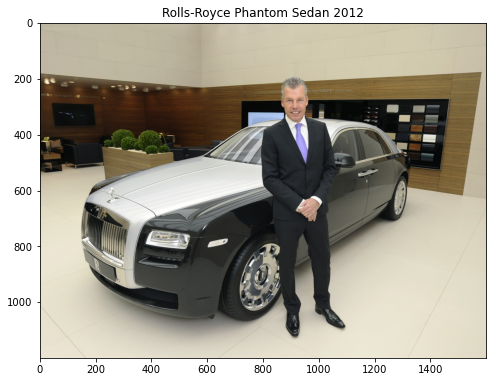

In [27]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

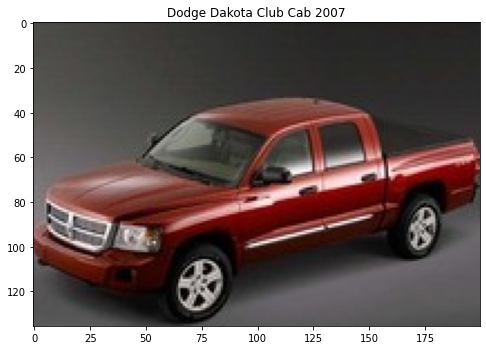

In [28]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

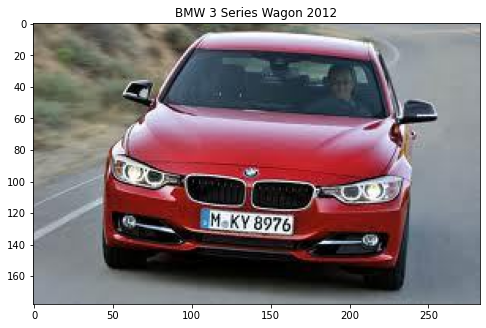

In [29]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

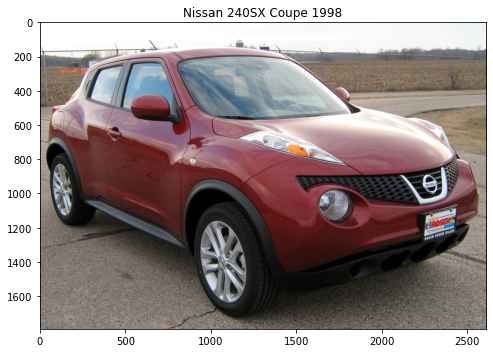

In [30]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

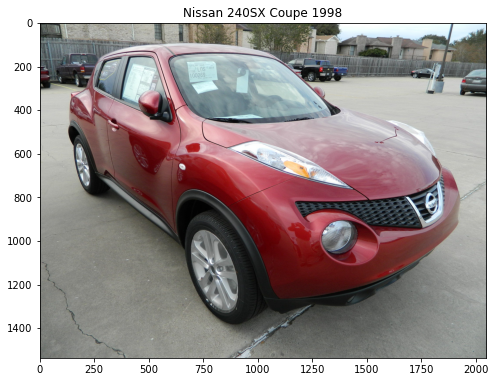

In [31]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

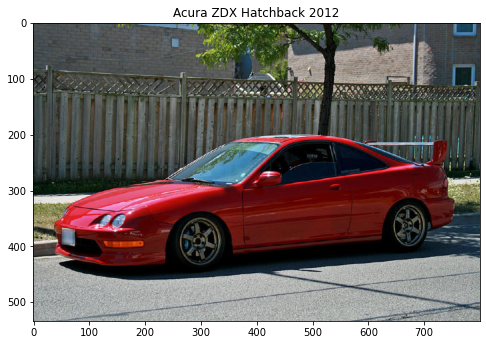

In [32]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

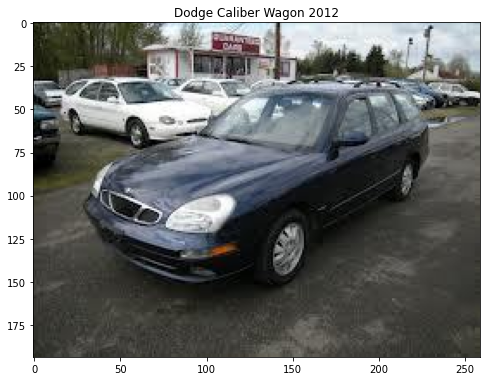

In [33]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

### Check distribution of data
Let's now check the data distribution. This is to check if there are enough images for each class and to maybe apply some data imbalance strategies for balancing the dataset.

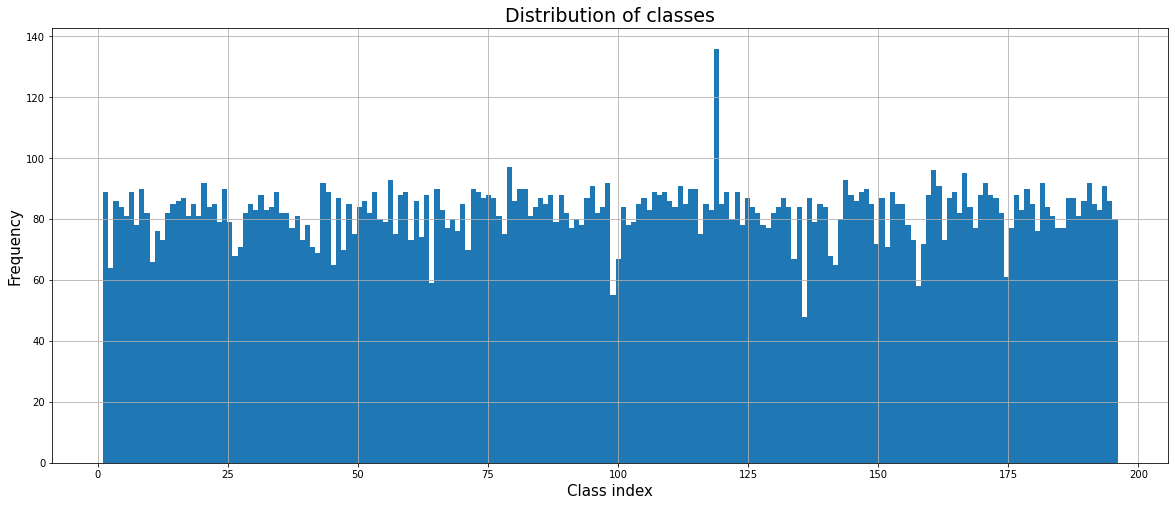

In [34]:
plt.figure(figsize=(20, 8))
df["class"].hist(bins=len(class_names))
plt.title("Distribution of classes", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

The dataset looks quite balanced. However, some classes seem to have less samples than others, which could result in a worse performance of the model on these classes. Let's later check if balancing can improve the overal performance! <br> <br>
Let's now check the distributions for the training and test set. This is important to ensure that the test set contains a similar distribution than the training set. For this dataset, almost the half of all images are in the test set. I think this is done in order to ensure that there are enough images of all classes in the test set. 

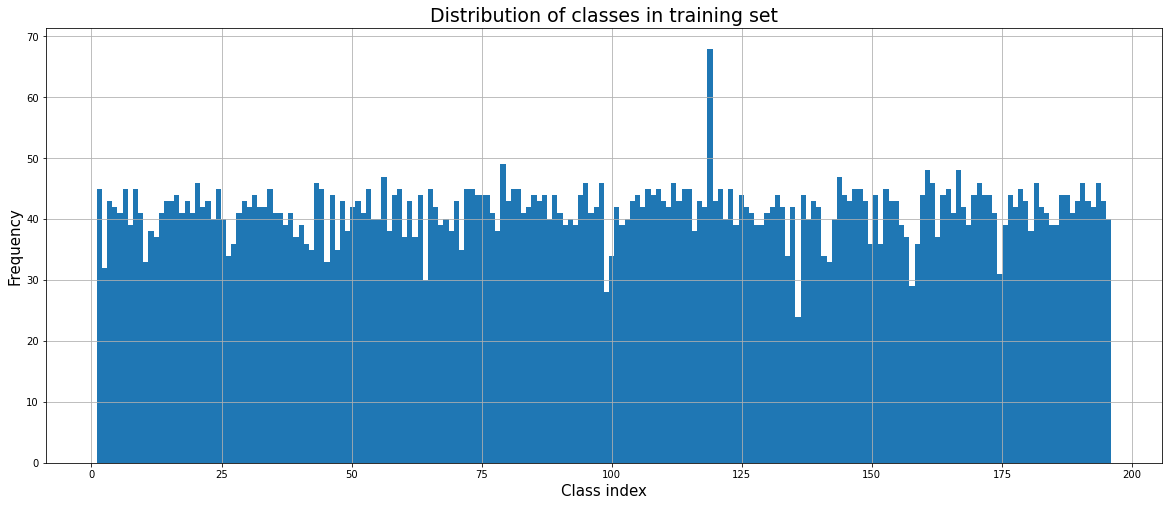

In [35]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 0]["class"].hist(bins=len(class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

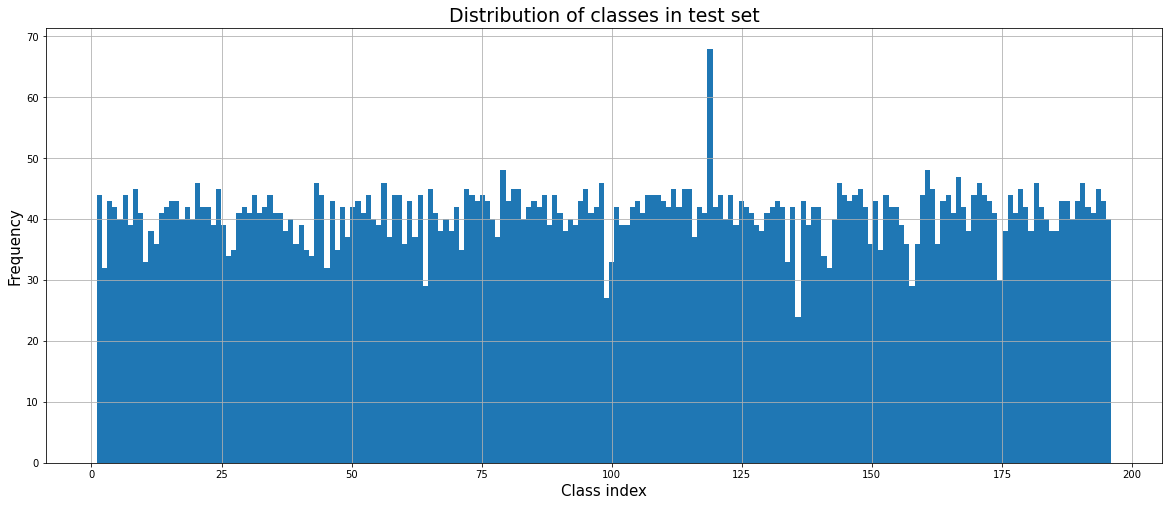

In [36]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 1]["class"].hist(bins=len(class_names))
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

As one can see, the distributions are almost the same! This is perfect, because the test set therefore represents the real distribution and we can better test the performance of the final model! <br> <br>
Let's now create a training and a validation set and let's check the distributions there. But before splitting, we should one-hot encode the labels!

In [37]:
# start with one-hot encoding the column "class"
df_encoded = pd.get_dummies(df, columns=["class"])
df_encoded.columns = ["filename", "test", *class_names]
df_encoded.head()

,filename,test,AM General Hummer SUV 2000,Acura RL Sedan 2012,Acura TL Sedan 2012,Acura TL Type-S 2008,Acura TSX Sedan 2012,Acura Integra Type R 2001,Acura ZDX Hatchback 2012,Aston Martin V8 Vantage Convertible 2012,...,Toyota Camry Sedan 2012,Toyota Corolla Sedan 2012,Toyota 4Runner SUV 2012,Volkswagen Golf Hatchback 2012,Volkswagen Golf Hatchback 1991,Volkswagen Beetle Hatchback 2012,Volvo C30 Hatchback 2012,Volvo 240 Sedan 1993,Volvo XC90 SUV 2007,smart fortwo Convertible 2012
0,000001.jpg,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000002.jpg,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000003.jpg,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000004.jpg,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000005.jpg,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

df_training = df_encoded.loc[df["test"] == 0]
df_test = df_encoded.loc[df["test"] == 1]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(df_training.drop(columns=class_names), df_training[class_names]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_training.iloc[train_index]
    df_val = df_training.iloc[test_index]

TRAIN: [2073 5425 3680 ... 6108 2866 5947] TEST: [5101 6728 7617 ... 3181 4207 4333]


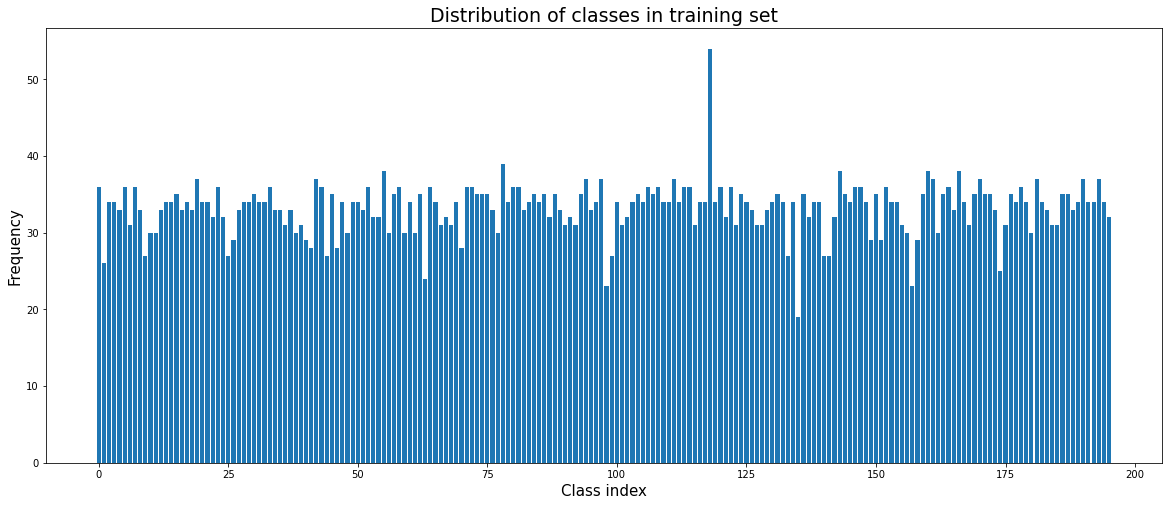

In [39]:
plt.figure(figsize=(20, 8))
count_classes_train = df_train[class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

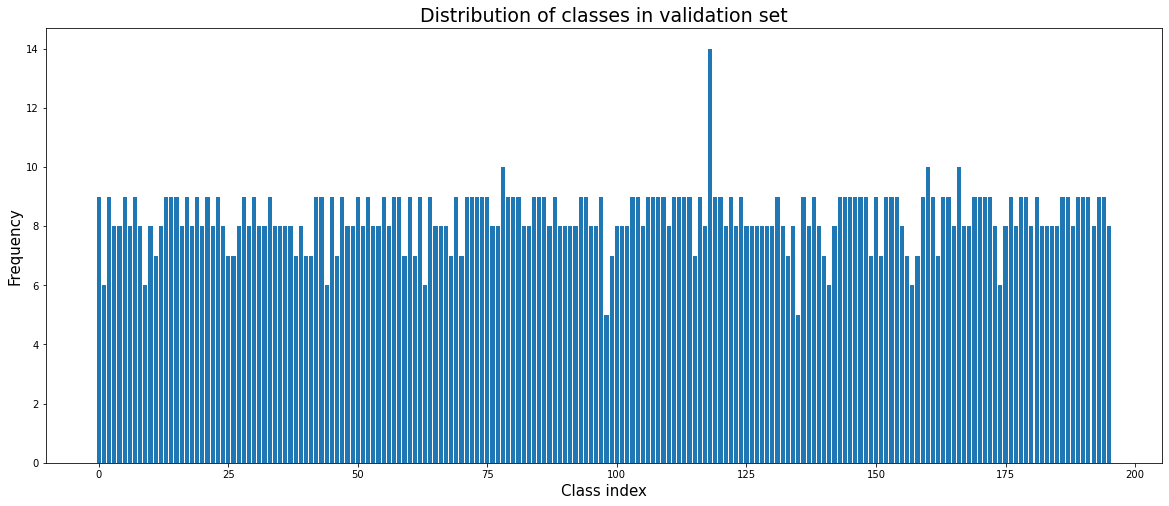

In [40]:
# check distribution of test set
plt.figure(figsize=(20, 8))
count_classes_test = df_val[class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_test)
plt.title("Distribution of classes in validation set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

## Create Tensorflow Input Pipeline

Let's first create a augmentation function that can be used by the image data generator. I selected the augmentations based on some experience and I applied them on an example image of the current dataset in the notebook "Check_Augmentations.ipynb". I directly started using these augmentations to prevent the models from quickly overfitting to the relatively small dataset. 

In [41]:
import imgaug.augmenters as iaa

def apply_augmentation(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0),
                iaa.Multiply((0.5, 1.5)),
                iaa.SaltAndPepper(0.1),
                [iaa.GammaContrast((0.8, 1.2)),iaa.Add((-60, 60))],
                iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                iaa.MotionBlur(k=15),
                iaa.Affine(scale=(0.5, 1.2)),
                iaa.Rotate((-45, 45)),
                iaa.ElasticTransformation(alpha=(50.0, 300.0), sigma=25.0),
              ]                
    for idx, aug in enumerate(aug_list):
        # only apply augmentation such that in total 10% of the images are not augmented
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
        rand_nr = np.random.rand()
        threshold = 0.21
        if isinstance(aug, list):
            rand_aug = np.random.randint(0, 2)
            input_image = np.clip(aug[rand_aug](images=input_image), 0., 255.) if rand_nr <= threshold else input_image
        else:
            input_image = np.clip(aug(images=input_image), 0., 255.) if rand_nr <= threshold else input_image

    return np.squeeze(input_image, axis=0)

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

In [43]:
# create datagenerators by calling flow_from_dataframe on them
path_to_images = r"data\car_ims"
batch_size = 8
shuffle = True
target_size = (256, 256)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filename", y_col=df_train.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col=df_val.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

Found 6515 validated image filenames.
Found 1629 validated image filenames.


Now: Check the format in order to ensure that the images are valid when they are entered into the CNN.

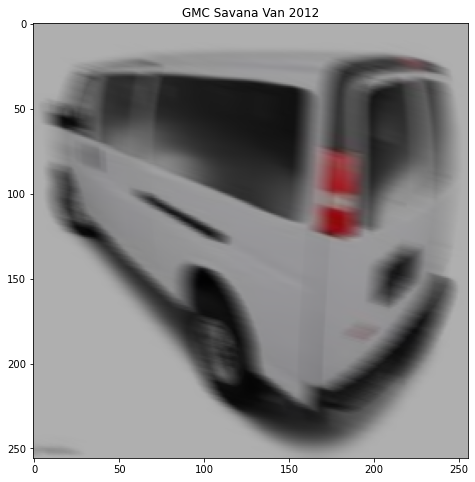

In [44]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

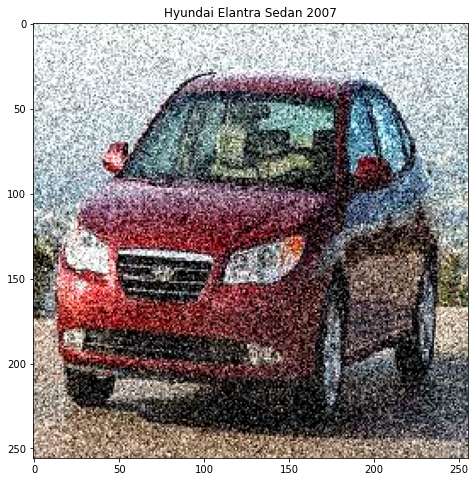

In [45]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

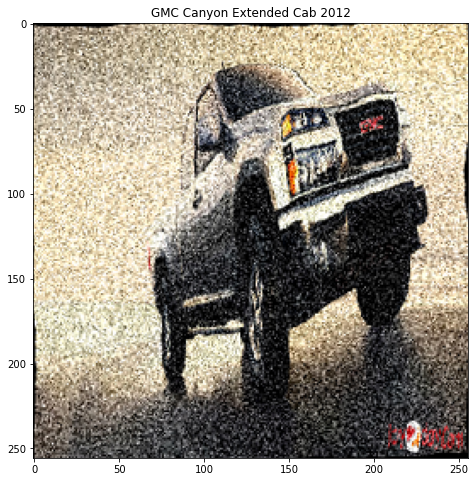

In [46]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

Let's now build a keras model factory to try out different cnns and use the best performing by considering the trade off between performance and complexity.

In [47]:
class KerasModelFactory():
    '''
    This class can be used to create a keras model and return it.
    '''
    
    def __init__(self):
        '''
        Constructor...
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str)):
                raise ValueError("Input model_name has the wrong datatype!")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "efficientnetb0":
            from tensorflow.keras.applications import EfficientNetB0
            model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "efficientnetb2":
            from tensorflow.keras.applications import EfficientNetB2
            model = EfficientNetB2(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "xception":
            from tensorflow.keras.applications import Xception
            model = Xception(weights=weights, include_top=False, input_shape=input_shape)
        else:
            from classification_models.tfkeras import Classifiers
            net, _ = Classifiers.get(model_name)
            model = net(input_shape=input_shape, weights=weights, include_top=False)
            
        # add a global spatial average pooling layer
        # this helps to decrease the risk of overfitting and to plot class activation maps
        x = model.output
        x = keras.layers.GlobalAveragePooling2D()(x)

        # and a fully connected output/classification layer
        predictions = keras.layers.Dense(num_classes, activation=activation_func)(x)

        # create the full network so we can train on it
        model = keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [48]:
# test keras factory
factory = KerasModelFactory()

Let's now compare different cnn encoders and choose the best one by considering the number of trainable parameters and the performance on the validation set. <br>
A cross-validation would be good for choosing the models. However, I decided to not use a cross validation in order to speed up the training process a little bit. <br> <br>
Steps for training the different encoders:
1. Train encoder for 40 epochs and store best validation f1-score of the encoder.
2. Create a plot with trainable parameters on x-axis and best score on y-axis. 
3. Use plot to decide which cnn architecture to use.

In [51]:
encoder_list = ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34", "resnet50"]
num_epochs = 40
results_dict = dict()
results_hists_dict = dict()
img_height, img_width = target_size
img_depth = 3

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(class_names), 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="auc"),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    results_dict[encoder] = [np.max(hist_dict.history["val_f1_score"]), np.max(hist_dict.history["val_accuracy"])]
    
    # save also the history in order to make some nice visualizations
    results_hists_dict[encoder] = hist_dict.history

Start training efficientnetb0...
Epoch 1/40
815/815 [==============================] - 244s 290ms/step - loss: 5.3053 - accuracy: 0.0098 - auc: 0.5198 - f1_score: 0.0000e+00 - val_loss: 5.2367 - val_accuracy: 0.0141 - val_auc: 0.5592 - val_f1_score: 0.0000e+00
Epoch 2/40
815/815 [==============================] - 230s 282ms/step - loss: 4.6956 - accuracy: 0.0779 - auc: 0.7627 - f1_score: 3.4759e-04 - val_loss: 5.8221 - val_accuracy: 0.0074 - val_auc: 0.5104 - val_f1_score: 0.0000e+00
Epoch 3/40
815/815 [==============================] - 236s 289ms/step - loss: 3.6613 - accuracy: 0.2218 - auc: 0.9113 - f1_score: 0.0056 - val_loss: 3.4620 - val_accuracy: 0.1989 - val_auc: 0.8980 - val_f1_score: 0.0375
Epoch 4/40
815/815 [==============================] - 238s 291ms/step - loss: 2.7850 - accuracy: 0.3903 - auc: 0.9555 - f1_score: 0.0615 - val_loss: 2.0831 - val_accuracy: 0.4745 - val_auc: 0.9687 - val_f1_score: 0.2600
Epoch 5/40
815/815 [==============================] - 231s 283ms/step -

Epoch 38/40
815/815 [==============================] - 227s 279ms/step - loss: 0.1634 - accuracy: 0.9546 - auc: 0.9989 - f1_score: 0.9545 - val_loss: 1.3888 - val_accuracy: 0.6783 - val_auc: 0.9554 - val_f1_score: 0.6695
Epoch 39/40
815/815 [==============================] - 239s 294ms/step - loss: 0.1727 - accuracy: 0.9577 - auc: 0.9981 - f1_score: 0.9564 - val_loss: 1.1649 - val_accuracy: 0.7250 - val_auc: 0.9626 - val_f1_score: 0.7220
Epoch 40/40
815/815 [==============================] - 228s 280ms/step - loss: 0.1673 - accuracy: 0.9552 - auc: 0.9991 - f1_score: 0.9561 - val_loss: 1.2194 - val_accuracy: 0.7084 - val_auc: 0.9644 - val_f1_score: 0.7108
Start training xception...
Epoch 1/40
815/815 [==============================] - 264s 318ms/step - loss: 5.2291 - accuracy: 0.0132 - auc: 0.5399 - f1_score: 0.0000e+00 - val_loss: 3.7917 - val_accuracy: 0.1486 - val_auc: 0.9057 - val_f1_score: 0.0136
Epoch 2/40
815/815 [==============================] - 262s 321ms/step - loss: 3.7330 -

Epoch 35/40
815/815 [==============================] - 261s 319ms/step - loss: 0.1143 - accuracy: 0.9679 - auc: 0.9993 - f1_score: 0.9685 - val_loss: 0.7355 - val_accuracy: 0.8355 - val_auc: 0.9764 - val_f1_score: 0.8293
Epoch 36/40
815/815 [==============================] - 261s 320ms/step - loss: 0.1250 - accuracy: 0.9670 - auc: 0.9989 - f1_score: 0.9658 - val_loss: 0.7675 - val_accuracy: 0.8379 - val_auc: 0.9733 - val_f1_score: 0.8320
Epoch 37/40
815/815 [==============================] - 260s 318ms/step - loss: 0.1149 - accuracy: 0.9679 - auc: 0.9992 - f1_score: 0.9677 - val_loss: 0.7624 - val_accuracy: 0.8214 - val_auc: 0.9772 - val_f1_score: 0.8194
Epoch 38/40
815/815 [==============================] - 265s 325ms/step - loss: 0.1041 - accuracy: 0.9709 - auc: 0.9993 - f1_score: 0.9698 - val_loss: 0.7264 - val_accuracy: 0.8343 - val_auc: 0.9779 - val_f1_score: 0.8352
Epoch 39/40
815/815 [==============================] - 261s 320ms/step - loss: 0.1127 - accuracy: 0.9668 - auc: 0.99

Epoch 32/40
815/815 [==============================] - 274s 336ms/step - loss: 0.1707 - accuracy: 0.9600 - auc: 0.9995 - f1_score: 0.9580 - val_loss: 0.5898 - val_accuracy: 0.8404 - val_auc: 0.9862 - val_f1_score: 0.8425
Epoch 33/40
815/815 [==============================] - 281s 345ms/step - loss: 0.1665 - accuracy: 0.9610 - auc: 0.9990 - f1_score: 0.9551 - val_loss: 0.6043 - val_accuracy: 0.8361 - val_auc: 0.9883 - val_f1_score: 0.8395
Epoch 34/40
815/815 [==============================] - 277s 339ms/step - loss: 0.1649 - accuracy: 0.9632 - auc: 0.9994 - f1_score: 0.9595 - val_loss: 0.5830 - val_accuracy: 0.8441 - val_auc: 0.9883 - val_f1_score: 0.8454
Epoch 35/40
815/815 [==============================] - 275s 337ms/step - loss: 0.1736 - accuracy: 0.9583 - auc: 0.9991 - f1_score: 0.9550 - val_loss: 0.6271 - val_accuracy: 0.8343 - val_auc: 0.9863 - val_f1_score: 0.8331
Epoch 36/40
815/815 [==============================] - 268s 329ms/step - loss: 0.1624 - accuracy: 0.9627 - auc: 0.99

Epoch 29/40
815/815 [==============================] - 188s 230ms/step - loss: 0.2819 - accuracy: 0.9323 - auc: 0.9973 - f1_score: 0.9265 - val_loss: 0.9072 - val_accuracy: 0.7643 - val_auc: 0.9778 - val_f1_score: 0.7628
Epoch 30/40
815/815 [==============================] - 229s 280ms/step - loss: 0.2885 - accuracy: 0.9305 - auc: 0.9975 - f1_score: 0.9255 - val_loss: 0.8495 - val_accuracy: 0.7753 - val_auc: 0.9805 - val_f1_score: 0.7674
Epoch 31/40
815/815 [==============================] - 179s 219ms/step - loss: 0.2640 - accuracy: 0.9349 - auc: 0.9986 - f1_score: 0.9336 - val_loss: 0.9106 - val_accuracy: 0.7630 - val_auc: 0.9796 - val_f1_score: 0.7624
Epoch 32/40
815/815 [==============================] - 178s 219ms/step - loss: 0.2583 - accuracy: 0.9413 - auc: 0.9972 - f1_score: 0.9367 - val_loss: 0.9208 - val_accuracy: 0.7514 - val_auc: 0.9794 - val_f1_score: 0.7602
Epoch 33/40
815/815 [==============================] - 175s 215ms/step - loss: 0.2561 - accuracy: 0.9406 - auc: 0.99

815/815 [==============================] - 180s 221ms/step - loss: 0.3086 - accuracy: 0.9195 - auc: 0.9970 - f1_score: 0.9174 - val_loss: 0.9818 - val_accuracy: 0.7526 - val_auc: 0.9715 - val_f1_score: 0.7507
Epoch 26/40
815/815 [==============================] - 181s 222ms/step - loss: 0.3460 - accuracy: 0.9104 - auc: 0.9964 - f1_score: 0.9107 - val_loss: 0.9382 - val_accuracy: 0.7667 - val_auc: 0.9719 - val_f1_score: 0.7576
Epoch 27/40
815/815 [==============================] - 182s 223ms/step - loss: 0.3083 - accuracy: 0.9225 - auc: 0.9973 - f1_score: 0.9191 - val_loss: 1.0406 - val_accuracy: 0.7459 - val_auc: 0.9705 - val_f1_score: 0.7458
Epoch 28/40
815/815 [==============================] - 180s 221ms/step - loss: 0.3117 - accuracy: 0.9234 - auc: 0.9962 - f1_score: 0.9182 - val_loss: 0.8622 - val_accuracy: 0.7925 - val_auc: 0.9750 - val_f1_score: 0.7925
Epoch 29/40
815/815 [==============================] - 180s 220ms/step - loss: 0.2940 - accuracy: 0.9263 - auc: 0.9972 - f1_scor

815/815 [==============================] - 206s 253ms/step - loss: 0.3516 - accuracy: 0.9066 - auc: 0.9976 - f1_score: 0.9068 - val_loss: 0.7981 - val_accuracy: 0.7974 - val_auc: 0.9826 - val_f1_score: 0.7861
Epoch 23/40
815/815 [==============================] - 207s 254ms/step - loss: 0.3831 - accuracy: 0.9007 - auc: 0.9965 - f1_score: 0.8939 - val_loss: 0.7280 - val_accuracy: 0.7993 - val_auc: 0.9840 - val_f1_score: 0.7924
Epoch 24/40
815/815 [==============================] - 218s 267ms/step - loss: 0.3096 - accuracy: 0.9170 - auc: 0.9978 - f1_score: 0.9153 - val_loss: 0.7668 - val_accuracy: 0.8005 - val_auc: 0.9825 - val_f1_score: 0.7986
Epoch 25/40
815/815 [==============================] - 229s 281ms/step - loss: 0.3379 - accuracy: 0.9087 - auc: 0.9974 - f1_score: 0.9074 - val_loss: 0.6576 - val_accuracy: 0.8275 - val_auc: 0.9830 - val_f1_score: 0.8273
Epoch 26/40
815/815 [==============================] - 207s 254ms/step - loss: 0.2941 - accuracy: 0.9245 - auc: 0.9977 - f1_scor

In [69]:
def create_accuracy_plots(results_hists_dict, figpath=r"figures\encoder_search_accuracy.pdf",
                          num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates an accuracy plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["accuracy"], label="Train")
        plt.plot(hist_dict["val_accuracy"], label="Val")
        
        if(idx > 2):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == 3):
            plt.ylabel("Accuracy")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.savefig(figpath)
    plt.show()

In [70]:
def create_loss_plots(results_hists_dict, figpath=r"figures\encoder_search_loss.pdf",
                      num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a loss plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["loss"], label="Train")
        plt.plot(hist_dict["val_loss"], label="Val")
        
        if(idx > 2):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == 3):
            plt.ylabel("Loss")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.savefig(figpath)
    plt.show()

In [71]:
def create_f1_plots(results_hists_dict, figpath=r"figures\encoder_search_f1_score.pdf",
                    num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a f1-score plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["f1_score"], label="Train")
        plt.plot(hist_dict["val_f1_score"], label="Val")
        
        if(idx > 2):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == 3):
            plt.ylabel("F1-Score")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.savefig(figpath)
    plt.show()

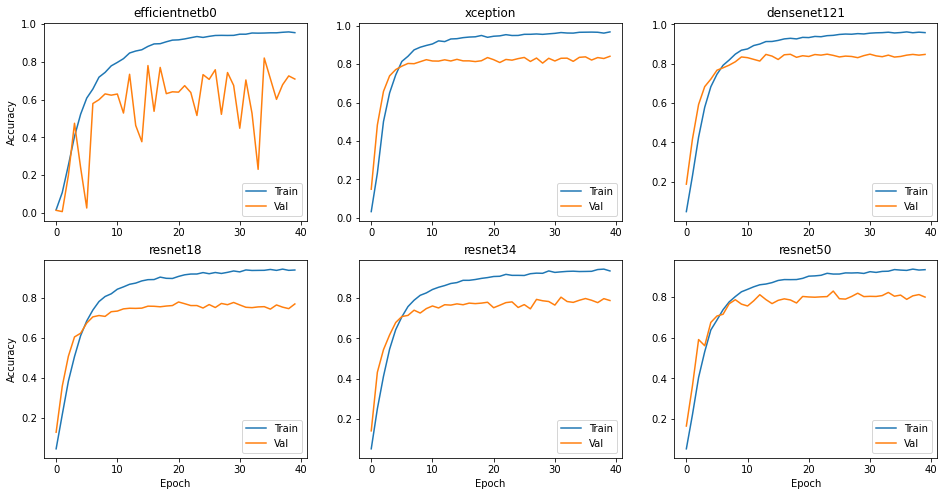

In [62]:
create_accuracy_plots(results_hists_dict)

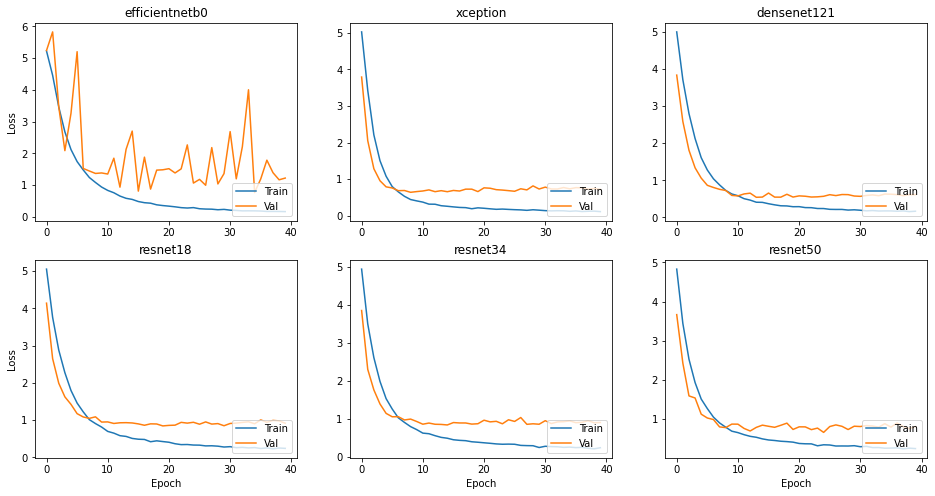

In [63]:
create_loss_plots(results_hists_dict)

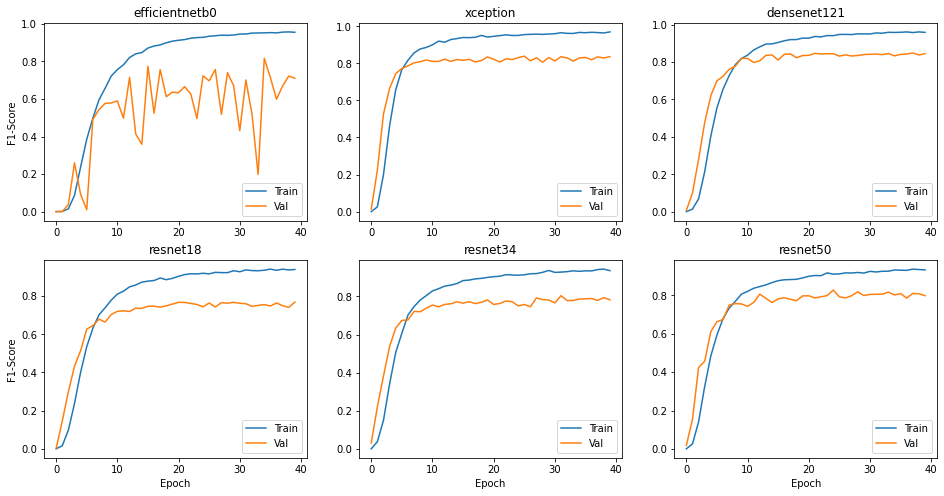

In [64]:
create_f1_plots(results_hists_dict)

In [58]:
(pd.DataFrame
 .from_dict(results_dict, orient="index", columns=["best_val_f1_score", "best_val_accuracy"])
 .sort_values(by=["best_val_f1_score"], ascending=False))

,best_val_f1_score,best_val_accuracy
densenet121,0.848489,0.848987
xception,0.838862,0.841007
resnet50,0.827261,0.827502
efficientnetb0,0.816388,0.819521
resnet34,0.803719,0.803560
resnet18,0.768697,0.777778


The DenseNet121 achieved the best f1-score and accuracy and is therefore used as the baseline encoder architecture for the remaining part of this project! <br>
By looking at these curves, one can see that there happened some overfitting (gap between validation and training curves). Let's later see if we can fix this!

As a next step, the network shall be trained with different image sizes in order to find the best image size. 

In [ ]:
list_image_sizes = [(128, 128), (192, 192), (224, 224), (256, 256)]
num_epochs = 30
encoder = "densenet121"
path_to_images = r"data\car_ims"
batch_size = 8
depth = 3 # using rgb
shuffle = True
img_size_results_dict = dict()
img_size_hists_dict = dict()

for target_size in list_image_sizes:
    print(f"Start training with target size of {target_size}...")
    img_height, img_width = target_size
    
    # setup input pipeline
    datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
    datagen_val = ImageDataGenerator(rescale = 1. / 255)
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                        x_col="filename", y_col=df_train.columns[2:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)

    valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                        x_col="filename", y_col=df_val.columns[2:], 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(class_names), 
                                                  input_shape=(img_height, img_width, depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="auc"),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    img_size_results_dict[target_size] = [np.max(hist_dict.history["val_f1_score"]), 
                                          np.max(hist_dict.history["val_accuracy"])]
    
    # add history 
    img_size_hists_dict[target_size] = hist_dict.history

Start training with target size of (128, 128)...
Found 6515 validated image filenames.
Found 1629 validated image filenames.
Epoch 1/30
 11/815 [..............................] - ETA: 3:29 - loss: 6.1715 - accuracy: 0.0000e+00 - auc: 0.4867 - f1_score: 0.0000e+00

In [ ]:
create_accuracy_plots(img_size_hists_dict, figpath=r"figures\image_size_results_accuracy.pdf", 
                      num_rows=2, num_cols=2)

In [ ]:
create_loss_plots(img_size_hists_dict, figpath=r"figures\image_size_results_loss.pdf", 
                      num_rows=2, num_cols=2)

In [ ]:
create_f1_plots(img_size_hists_dict, figpath=r"figures\image_size_results_f1_score.pdf", 
                      num_rows=2, num_cols=2)

In [ ]:
pd.DataFrame.from_dict(img_size_results_dict, orient="index", columns=["val_f1_score", "val_accuracy"])

As one would have guessed: The larger the images, the better the performance of the model. From image size 192x192 to 256x256, there is still a 5% increase in accuracy. And in my case, it's not that important to save some computation power and space of the model. Therefore, I decided to choose the image size of 256x256 pixels for further processing! <br><br> 
Perfect. Now we also have our optimal image size. Let's now continue and check whether we should apply some oversampling to balance the dataset or not. <br> <br>
Important: Oversampling should only be applied on the training set and not on the overal dataset! This is to ensure that no images of the training set are also in the validation or even worse in the test set!

In [ ]:
def oversample_dataframe(df):
    # create copy of dataframe
    df_copy = df.copy()
    
    # find majortiy class count
    count_majority = df_copy[df_copy.columns[2:]].sum().max()
    
    # loop over all classes and oversample until count_majority number of samples are reached
    balanced_columns_list = list()
    for col in df_copy.columns[2:]:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_1 = df_copy[df_copy[col] == 1]
        # get the number of samples within that class
        count_class_1 = df_class_1.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_oversampled = df_class_1.sample(count_majority - count_class_1, replace=True)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(pd.concat([df_class_1, df_oversampled]))
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

In [ ]:
df_train_oversampled = oversample_dataframe(df_train)

plt.figure(figsize=(20, 8))
count_classes_train = df_train_oversampled[new_class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

That looks good. Now we have a fully balanced dataframe. Let's now create the training loop for comparing the fully balanced to the imbalanced training. <br> 
We only have to train the oversampling case, because we can reuse the results from the network with our new target image size as the results for the imbalanced learning.

In [ ]:
target_image_size = (256, 256)
img_height, img_width = target_image_size
num_epochs = 30
encoder = "densenet121"
path_to_images = r"data\car_ims"
batch_size = 8
depth = 3 # using rgb
oversampling_results = list()

# setup input pipeline
datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train_oversampled, directory=path_to_images,
                                                    x_col="filename", y_col=df_train_oversampled.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col=df_val.columns[2:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(class_names), 
                                              input_shape=(img_height, img_width, depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# define the metrics
metrics_list = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
]

# compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

# fit the model for num_epochs epochs
with tf.device("/GPU:0"):
    hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)

# get the maximum validation f1-score and validation accuracy and store them
oversampling_results = [np.max(hist_dict.history["val_f1_score"]), 
                        np.max(hist_dict.history["val_accuracy"])]

Now let's come to the last evaluation step: Searching good hyperparameters using Bayesian Hyperparameter search.

In [ ]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from skopt.callbacks import CheckpointSaver

In [ ]:
# create hyperparameter search space

dim_learning_rate = Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate')
dim_batch_size = Categorical([8, 16], name='batch_size')
dim_optimizer = Categorical(categories=["Adam", "RMSProp"], name="optimizer")
dim_decay = Real(low=0.95, high=1, name="decay_rate")
dim_steps_multiplier = Real(low=1, high=3, name="decay_steps")

dimensions = [dim_learning_rate,
              dim_batch_size,
              dim_optimizer,
              dim_decay,
              dim_steps_multiplier]

default_parameters = [[1e-5, 16, "Adam", 1, 3],
                      [1e-3, 16, "Adam", 0.95, 3],
                      [1e-5, 16, "RMSProp", 1, 3],
                      [1e-3, 16, "RMSProp", 0.95, 3]
                     ]

In [ ]:
# let's write a create model function to easily return the keras model with all required parameters and setup

def create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train, encoder, new_class_names):
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(class_names), 
                                                  input_shape=(32, 32, 3),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                 decay_steps= int(decay_steps * steps_per_epoch_train),
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)
        
    if optimizer == "RMSProp":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule,
                                                       rho=0.9, momentum=0.9, name="RMSprop")
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name="Adam")
        
    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics_list)
    
    return model

In [ ]:
# let's now create the fitness function that shall be optimized

def create_fitness_func(encoder, class_names):

    @use_named_args(dimensions=dimensions)
    def fitness(learning_rate, batch_size, optimizer, decay_rate, decay_steps):

        # create data generators in order to load the images
        datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
        datagen_val = ImageDataGenerator(rescale = 1. / 255)

        train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                            x_col="filename", y_col=df_train.columns[2:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                            x_col="filename", y_col=df_val.columns[2:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        # set parameters for learning
        steps_per_epoch_train = train_generator.__len__()
        steps_per_epoch_val = valid_generator.__len__()

        # create model
        model = create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train,
                             encoder, class_names)

        history = model.fit(train_generator, epochs=1, verbose=1, validation_data=valid_generator)

        f1_score = np.amax(history.history["val_f1_score"])

        if np.isnan(f1_score):
            f1_score = -1.0

        print(f"\nBest Validation F1-Score: {f1_score}\n")

        # dump results to json file
        dict_results = {}
        dict_results["learning_rate"] = learning_rate
        dict_results["batch_size"] = int(batch_size)
        dict_results["optimizer"] = optimizer
        dict_results["decay_rate"] = decay_rate
        dict_results["decay_steps"] = decay_steps
        dict_results["best_val_f1_score"] = f1_score

        # delete model from memory
        del model

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
        tf.compat.v1.reset_default_graph()

        # the optimizer aims for the lowest score, so return negative f1_score
        return -f1_score
    return fitness

In [ ]:
encoder = "densenet121"

gp_result = gp_minimize(func=create_fitness_func(encoder, class_names),
                        dimensions=dimensions,
                        n_calls=12,
                        n_jobs=-1,
                        acq_func="LCB",
                        kappa = 10,
                        n_initial_points=4,
                        x0=default_parameters,
                        verbose=True)

In [ ]:
# Next Steps: 
# 1. Check data distribution
# 2. Create tensorflow input pipeline with normalization, conversion to grayscale
# 3. Use small images to find best suited cnn
# 4. Apply data augmentation.
# 5. Check different images sizes on winning cnn.
# 6. Check oversampling vs. imblanced. 
# 7. Apply Bayesian Hyperparameter Search to find best hyperparameters.
# 8. Train final model.
# 9. Plot Class Activation Maps.